In [1]:
from pylab import *
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors.kde import KernelDensity
from matplotlib import path
import random
from mpl_toolkits.basemap import Basemap 
import numpy as np
import pandas as pd

/home/santiagotc/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Making plot without normalizing!
Total number of points 2


ValueError: 'vertices' must be a 2D list or array with shape Nx2

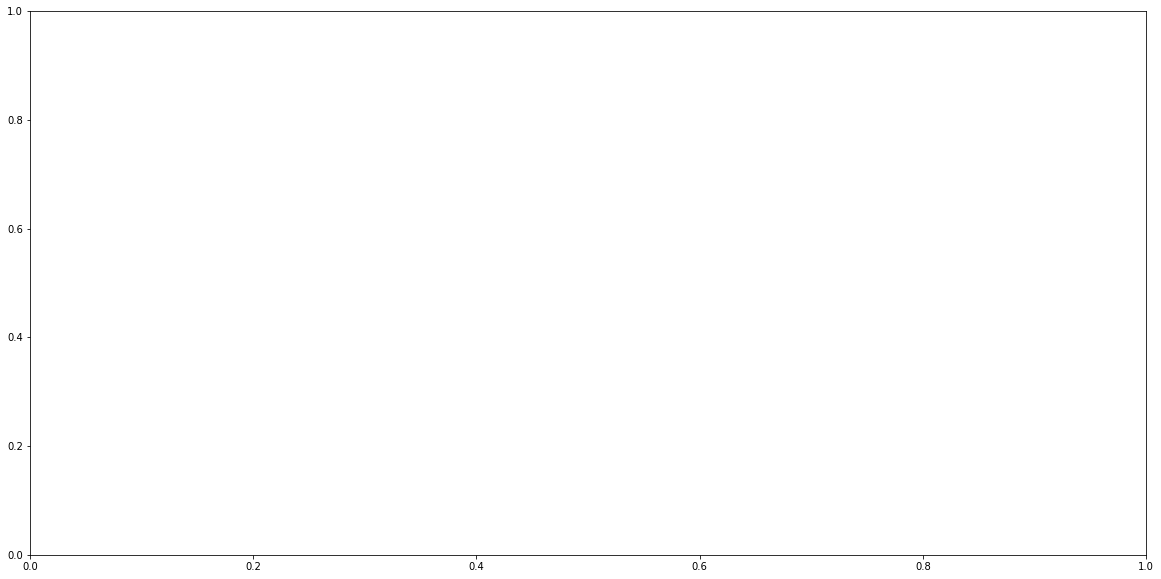

In [22]:
def pnpoly(x, y, xyverts):
    """
    Included code for this matplotlib method directly in file b/c some versions don't have it. 
    inside = pnpoly(x, y, xyverts)
    Return 1 if x,y is inside the polygon, 0 otherwise.
    *xyverts*
        a sequence of x,y vertices.
    A point on the boundary may be treated as inside or outside.
    .. deprecated:: 1.2.0
        Use :meth:`~matplotlib.path.Path.contains_point` instead.
    """
    p = path.Path(xyverts)
    return p.contains_point([x, y])

def points_inside_poly(xypoints, xyverts):
    """
    Included code for this matplotlib method directly in file b/c some versions don't have it. 
    mask = points_inside_poly(xypoints, xyverts)
    Returns a boolean ndarray, True for points inside the polygon.
    *xypoints*
        a sequence of N x,y pairs.
    *xyverts*
        sequence of x,y vertices of the polygon.
    A point on the boundary may be treated as inside or outside.
    .. deprecated:: 1.2.0
        Use :meth:`~matplotlib.path.Path.contains_points` instead.
    """
    p = path.Path(xyverts)
    return p.contains_points(xypoints)

def points_in_polys(points, polys):
    """
    This method masks off the water (where data will be unreliable).
    """
    result = []
    for i, poly in enumerate(polys):
        if i == 0:
            mask = points_inside_poly(points, poly)
        else:
            mask = mask | points_inside_poly(points, poly)
    return np.array(mask)

def makeNearestNeighborsDensityPlot(filename, col_of_interest = None, title_string = None, min_lat = 4.47, max_lat = 4.78, min_lon = -74.21, max_lon = -74.02, maskOffWater = True, cmap = 'bwr', color_min = None, color_max = None, n_neighbors = 20, res = .2, weights = lambda x:np.exp(-(x ** 2) / 3 ** 2)):
    
    """
    Makes a map of the density of events. Red = higher density, blue = lower density. 
    filename: the name of the file that contains the data. See sample_data.csv for an example. Should contain at least two columns: lat (latitude) and lon (longitude). 
    col_of_interest: If None, uses kernel density estimation to just plot the overall density of events. If not None, col_of_interest should be a column that contains 0s and 1s, where 1 denotes events of interest and 0 denotes background events; then uses k-nearest neighbors to estimate the fraction of events which are 1s. 
    title_string: The title for the map. 
    min_lat, max_lat, min_long, max_long: the boundaries of the map, in degrees. Negative longitudes = west; negative latitudes = south. By default set to borders of North America. 
    maskOffWater: if True, does not map for water. True by default. 
    cmap: the name of the colormap to use. See http://matplotlib.org/examples/color/colormaps_reference.html for list of options. 
    color_min, color_max: which densities are mapped to the maximum and minimum colors. For k-nearest neighbors, set to 0 and 1 by default; for kernel density estimation, set to 0 and the maximum density estimate by default. May have to play with these to get informative maps. 
    n_neighbors: for k-nearest neighbors, the number of neighbors to use to compute densities. Try increasing if the map is very spiky. 
    res: how high-resolution the map is. Lower numbers = HIGHER resolution (but will take longer to make.)
    weights: for k-nearest neighbors, how to weight the points as a function of distance. By default uses a Gaussian kernel. Don't play with this unless you know what you're doing. 
    """
    d = pd.read_csv(filename)
    if not (('lat' in d.columns) and ('lon' in d.columns)):
        raise Exception('Error: dataset must contain lat and lon')
    
    if (col_of_interest is not None) and (col_of_interest not in d.columns):
        raise Exception('Error: dataset must contain column labeled %s' % col_of_interest)
        if not set(d[col_of_interest]) == set([0, 1]):
            raise Exception("Error: column %s must contain 0s and 1s" % col_of_interest)
    #Filter for events with locations. 
    geolocated = d.dropna(subset = ['lat', 'lon']) 
    idxs = (geolocated['lat'] > min_lat) & (geolocated['lat'] < max_lat) 
    idxs = idxs &  (geolocated['lon'] > min_lon) & (geolocated['lon'] < max_lon) 
    geolocated = geolocated.loc[idxs]
    
    #Fit the appropriate model: k-nearest neighbors if col_of_interest is not None, otherwise Kernel Density Estimation. 
    if col_of_interest is not None:
        model = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
        print ('Total number of points', len(geolocated), 'in column of interest nonzero', geolocated[col_of_interest].sum())
        model.fit(geolocated[['lat', 'lon']], geolocated[col_of_interest])   
    else:
        print ('Total number of points', len(geolocated))
        model = KernelDensity(kernel='gaussian', bandwidth = 3).fit(geolocated[['lat', 'lon']])
    
    #Create a grid of points at which to predict. 
    x = np.arange(min_lat, max_lat, res)
    y = np.arange(min_lon, max_lon, res)
    X, Y = meshgrid(x, y)
    numel = len(X) * len(X[0, :])
    Z = np.zeros(X.shape)
    unraveled_x = X.reshape([numel, 1])
    unraveled_y = Y.reshape([numel, 1])
    data_to_eval = np.hstack([unraveled_x, unraveled_y])
    
    #Make predictions using appropriate model. 
    if col_of_interest is not None:
        density = model.predict_proba(data_to_eval)[:, 1]
        if color_min is None:
            color_min = 0
        if color_max is None:
            color_max = 1
    else:
        density = np.exp(model.score_samples(data_to_eval))
        if color_min is None:
            color_min = 0
        if color_max is None:
            color_max = density.max()

    #Make map. 
    figure(figsize = [20, 10])    
    m = Basemap(llcrnrlat = min_lat, urcrnrlat = max_lat, llcrnrlon = min_lon, urcrnrlon=max_lon, resolution='l', fix_aspect = False)
    if maskOffWater:
        m.drawcoastlines()
        x, y = m(data_to_eval[:,1], data_to_eval[:,0])
        loc = np.c_[x, y]
        polys = [p.boundary for p in m.landpolygons]
        on_land = points_in_polys(loc, polys) 
        density[~on_land] = (color_min + color_max) / 2
    
    density = density.reshape(X.shape)
    contourf(Y, X, density, levels = np.linspace(color_min, color_max, 25))
    m.drawcoastlines(linewidth = 2)
    m.drawcountries(linewidth = 2)
    m.drawstates(linewidth = 2)
    colorbar()
    set_cmap(cmap)
    if title_string is not None:
        title(title_string, fontsize = 30, fontweight = 'bold')
        savefig('%s' % title_string, dpi = 300, format = 'png')
    else:
        savefig('plot.png', dpi = 300, format = 'png')
    show()

def generateSimulatedData():
    """
    This generates some (not very realistic) simulated data.
    """
    lats = list(35 + (np.random.random([2000,]) - .5) * 10)
    longs = list(-100 + (np.random.random([1000,]) - .5) * 20) + list(-80 + (np.random.random([1000,]) - .5) * 20)
    is_pizza_shop = [1 for i in range(1000)] + [0 for i in range(1000)] 
    d = pd.DataFrame({'lat':lats, 'lon':longs, 'shop_is_pizza_shop':is_pizza_shop})
    d.to_csv('sample_data.csv', index = False)

if __name__ == '__main__':
    #generateSimulatedData()
    filename = 'sample_data.csv'
    print ("Making plot without normalizing!")
    makeNearestNeighborsDensityPlot(filename, col_of_interest = None, title_string = "Overall Shop Density")
    #print ("Making plot with normalizing!")
    #makeNearestNeighborsDensityPlot(filename, col_of_interest = "shop_is_pizza_shop", title_string = "Fraction of Shops which are Pizza Shops")




In [1]:
import geocoder

In [2]:
loc = geocoder.google('Mountain View, CA')

In [3]:
print(loc.latlng)

None


In [4]:
print(loc)

<[REQUEST_DENIED] Google - Geocode [empty]>


In [30]:
import json

with open('BogotaNeighborhood.geojson') as data:
    geo = json.load(data)
    
    if 'SCANOMBRE' in geo:
    for attachment in geo["attachment"]:
        print (attachment)

In [53]:
geo['features'][0]['geometry']['coordinates'][0]

-74.13010208434366

In [50]:
geo['features'][0]['properties']['SCANOMBRE']

'EL MOCHUELO II URBANO'

In [51]:
len(geo['features'])

1169

In [54]:
name = []
lat = []
lon = []
for i in range(len(geo['features'])):
    name.append(geo['features'][i]['properties']['SCANOMBRE'])
    lat.append(geo['features'][i]['geometry']['coordinates'][1])
    lon.append(geo['features'][i]['geometry']['coordinates'][0])

In [56]:
dic = {'name':name, 'lat':lat, 'lon':lon}

In [57]:
df = pd.DataFrame(dic)

In [58]:
df

,name,lat,lon
0,EL MOCHUELO II URBANO,4.525412,-74.130102
1,SAN PABLO BOSA,4.604625,-74.189834
2,LOS SOCHES,4.499816,-74.088686
3,EL PORTAL DEL DIVINO,4.486215,-74.097791
4,LUCERO DEL SUR,4.551248,-74.141236
...,...,...,...
1164,LISBOA,4.715505,-74.035929
1165,PROVIVIENDA OCCIDENTAL,4.614115,-74.144426
1166,EL NUEVO PORTAL II,4.490772,-74.100689
1167,SANTA BARBARA CENTRAL,4.699766,-74.037916


In [60]:
df.to_csv('coordenadas_barrios_bogota.csv', index=False)